In [1]:
import requests
import pandas as pd
import os
from dotenv import load_dotenv
from neo4j import GraphDatabase, basic_auth
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import openai
import numpy as np


## Load data

In [2]:
data = pd.read_csv('../data/rag_comparison_data.csv')



## Custom functions

In [41]:

def connect_to_graph():
    auth = basic_auth(graph_usr, graph_psw)
    return GraphDatabase.driver(graph_uri, auth=auth)

def run_cypher(cypher_query):
    with connect_to_graph() as sdb:
        with sdb.session() as session:
            result = session.run(cypher_query)
            out = []
            for row in result:
                out.append((row['d_name'], row['r_type'], row['g_label'], row['g_name'], row['relationship_properties']))
    return out


def lucene_search(query, source):
    source_search_uri = f"https://spoke.rbvi.ucsf.edu/api/v1/search/{source}/{query}"
    source_search_resp = requests.get(source_search_uri)
    return source_search_resp

def get_context_using_lucene_search(query):
    source = 'Disease'
    source_resp = lucene_search(query, source)         
    if source_resp.status_code == 200:
        source_resp_data = source_resp.json()
        source_name = source_resp_data[0]['name']
    else:
        return ''
    cypher = f'''
        MATCH(d:Disease{{name:"{source_name}"}})-[r]-(g) 
        RETURN DISTINCT d.name AS d_name, TYPE(r) AS r_type, LABELS(g) AS g_label, g.name AS g_name, PROPERTIES(r) AS relationship_properties        
    '''
    graph_out = run_cypher(cypher)
    context = ''
    if len(graph_out) > 0:        
        for i in graph_out:
            try:
                prov = ', '.join(i[3]["sources"])            
            except:
                try:
                    prov = i[3]["source"]
                except:
                    prov = ''
            context += 'Disease ' + i[0] + ' ' + i[1].split('_')[0].lower() + ' ' + i[2][0] + ' ' + i[3] + f'. Provenance of this association is {prov}. ' + '\n' + str(i[4]) 
    return context



def chat_completion_with_token_usage(instruction, system_prompt, chat_model_id, chat_deployment_id, temperature):
    response = openai.ChatCompletion.create(
        temperature=temperature,
        deployment_id=chat_deployment_id,
        model=chat_model_id,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": instruction}
        ]
    )
    return response['choices'][0]['message']['content'], response.usage.total_tokens
    

## OpenAI credentials

In [42]:
load_dotenv(os.path.join(os.path.expanduser('~'), '.gpt_config.env'))

api_key = os.environ.get('API_KEY')
api_version = os.environ.get('API_VERSION')
resource_endpoint = os.environ.get('RESOURCE_ENDPOINT')
openai.api_type = 'azure'
openai.api_key = api_key
if resource_endpoint:
    openai.api_base = resource_endpoint
if api_version:
    openai.api_version = api_version



## Graph credentials

In [43]:
load_dotenv(os.path.join(os.path.expanduser('~'), '.spoke_neo4j_config.env'))
graph_usr = os.environ.get('NEO4J_USER')
graph_psw = os.environ.get('NEO4J_PSW')
graph_uri = os.environ.get('NEO4J_URL')
database = os.environ.get('NEO4J_DB')


## Setting system prompt for LLM

In [ ]:
system_prompt = '''
 You are an expert biomedical researcher. 
 For answering the Question at the end with brevity, you need to first read the Context provided. 
 Then give your final answer briefly, by citing the Provenance information from the context. 
 You can find Provenance from the Context statement 'Provenance of this association is <Provenance>'. 
 Do not forget to cite the Provenance information. 
 Note that, if Provenance is 'GWAS' report it as 'GWAS Catalog'. 
 If Provenance is 'DISEASES' report it as 'DISEASES database - https://diseases.jensenlab.org'. 
 Additionally, when providing drug or medication suggestions, give maximum information available and then advise the user to seek guidance from a healthcare professional as a precautionary measure.
'''

chat_model = 'gpt-4-32k'
temperature = 0



## Example query for Lucene based RAG

In [45]:

query = "Is Parkinson's disease associated with PINK1 gene?"

context = get_context_using_lucene_search(query)

prompt = f'''
Context: {context}
Question: {query}
'''
output, token_usage = chat_completion_with_token_usage(prompt, system_prompt, chat_model, chat_model, temperature)

print(output)


Yes, Parkinson's disease is associated with the PINK1 gene. Provenance of this association is not provided in the context.


## Example query for Lucene based RAG (after perturbation)

In [46]:

query = "Is parkinson's disease associated with pink1 gene?"

context = get_context_using_lucene_search(query)

prompt = f'''
Context: {context}
Question: {query}
'''
output, token_usage = chat_completion_with_token_usage(prompt, system_prompt, chat_model, chat_model, temperature)

print(output)


Yes, Parkinson's disease is associated with the PINK1 gene. Provenance of this association is not provided in the context.


## Lucene based context extraction

In [5]:
%%time

lucene_based_context_list = []
for row_index, row in tqdm(data.iterrows()):
    query = row['question']
    lucene_based_context_list.append(get_context_using_lucene_search(query))

data['extracted_context'] = lucene_based_context_list
# data_non_empty_context = data[data.extracted_context != '']



100it [00:43,  2.31it/s]

CPU times: user 14.1 s, sys: 1.04 s, total: 15.1 s
Wall time: 43.3 s


## Lucene based context extraction - after query perturbation

In [6]:
%%time

lucene_based_context_list = []
for row_index, row in tqdm(data.iterrows()):
    query = row['question_perturbed']
    lucene_based_context_list.append(get_context_using_lucene_search(query))

data['extracted_context_after_perturbation'] = lucene_based_context_list

# data_non_empty_context_after_perturbation = data[data.extracted_context_after_perturbation != '']


100it [01:00,  1.66it/s]

CPU times: user 19.5 s, sys: 1.32 s, total: 20.8 s
Wall time: 1min


In [8]:
%%time

full_text_track_output = []
full_text_track_token_usage = []
for row_index, row in tqdm(data.iterrows()):
    query = row['question']
    context = row['extracted_context']
    prompt = f'''
    Context: {context}
    Question: {query}
    '''
    try:
        output, token_usage = chat_completion_with_token_usage(prompt, system_prompt, chat_model, chat_model, temperature)
        full_text_track_output.append(output)
        full_text_track_token_usage.append(token_usage)
    except:
        full_text_track_output.append(None)
        full_text_track_token_usage.append(None)
    
data['full_text_index_answer'] = full_text_track_output
data['token_usage'] = full_text_track_token_usage


100it [05:10,  3.11s/it]

CPU times: user 1.94 s, sys: 484 ms, total: 2.42 s
Wall time: 5min 10s


In [9]:
%%time

full_text_track_output = []
full_text_track_token_usage = []
for row_index, row in tqdm(data.iterrows()):
    query = row['question_perturbed']
    context = row['extracted_context_after_perturbation']
    prompt = f'''
    Context: {context}
    Question: {query}
    '''
    try:
        output, token_usage = chat_completion_with_token_usage(prompt, system_prompt, chat_model, chat_model, temperature)
        full_text_track_output.append(output)
        full_text_track_token_usage.append(token_usage)
    except:
        full_text_track_output.append(None)
        full_text_track_token_usage.append(None)
    
data['full_text_index_answer_after_perturbation'] = full_text_track_output
data['token_usage_after_perturbation'] = full_text_track_token_usage


100it [04:53,  2.94s/it]

CPU times: user 1.81 s, sys: 503 ms, total: 2.31 s
Wall time: 4min 53s


In [17]:
data_no_nan = data.dropna(subset=['full_text_index_answer'])
data_yes_count_df = data_no_nan[data_no_nan.full_text_index_answer.str.contains('Yes')]
data_yes_count = data_yes_count_df.shape[0]
indices_to_remove = data_yes_count_df.index.tolist()
data_no_nan = data_no_nan.drop(indices_to_remove)
data_no_nan.loc[:, 'contains_pvalue'] = data_no_nan.apply(lambda row: str(row['gwas_pvalue']) in str(row['full_text_index_answer']), axis=1)
data_p_value_correct_retrieval_count = data_no_nan[data_no_nan.contains_pvalue==True].shape[0]
data_total_correct_retrieval = data_yes_count + data_p_value_correct_retrieval_count

full_text_index_based_total_correct_retrieval_percentage = 100*data_total_correct_retrieval/data.shape[0]

print(f'Correct retrieval percentage for Full-text index based retrieval {full_text_index_based_total_correct_retrieval_percentage}%')


Correct retrieval percentage for Full-text index based retrieval 61.0%


In [21]:
data_no_nan = data.dropna(subset=['full_text_index_answer_after_perturbation'])
data_yes_count_df = data_no_nan[data_no_nan.full_text_index_answer_after_perturbation.str.contains('Yes')]
data_yes_count = data_yes_count_df.shape[0]
indices_to_remove = data_yes_count_df.index.tolist()
data_no_nan = data_no_nan.drop(indices_to_remove)
data_no_nan.loc[:, 'contains_pvalue'] = data_no_nan.apply(lambda row: str(row['gwas_pvalue']) in str(row['full_text_index_answer_after_perturbation']), axis=1)
data_p_value_correct_retrieval_count = data_no_nan[data_no_nan.contains_pvalue==True].shape[0]
data_total_correct_retrieval = data_yes_count + data_p_value_correct_retrieval_count

full_text_index_based_total_correct_retrieval_perturbed_percentage = 100*data_total_correct_retrieval/data.shape[0]

print(f'Correct retrieval percentage for Full-text index based retrieval after name perturbation {full_text_index_based_total_correct_retrieval_perturbed_percentage}%')


Correct retrieval percentage for Full-text index based retrieval after name perturbation 58.0%


## KG-RAG

In [22]:
kg_rag = pd.read_csv('../data/results/kg_rag_output.csv')

In [23]:

kg_rag_no_nan = kg_rag.dropna(subset=['kg_rag_answer'])
kg_rag_yes_count_df = kg_rag_no_nan[kg_rag_no_nan.kg_rag_answer.str.contains('Yes')]
kg_rag_yes_count = kg_rag_yes_count_df.shape[0]
indices_to_remove = kg_rag_yes_count_df.index.tolist()
kg_rag_no_nan = kg_rag_no_nan.drop(indices_to_remove)
kg_rag_no_nan.loc[:, 'contains_pvalue'] = kg_rag_no_nan.apply(lambda row: str(row['gwas_pvalue']) in str(row['kg_rag_answer']), axis=1)
kg_rag_p_value_correct_retrieval_count = kg_rag_no_nan[kg_rag_no_nan.contains_pvalue==True].shape[0]
kg_rag_total_correct_retrieval = kg_rag_yes_count + kg_rag_p_value_correct_retrieval_count


kg_rag_total_correct_retrieval_percentage = 100*kg_rag_total_correct_retrieval/kg_rag.shape[0]

print(f'Correct retrieval percentage for KG-RAG {kg_rag_total_correct_retrieval_percentage}%')


Correct retrieval percentage for KG-RAG 97.0%


In [24]:


kg_rag_no_nan = kg_rag.dropna(subset=['kg_rag_answer_perturbed'])
kg_rag_yes_count_df = kg_rag_no_nan[kg_rag_no_nan.kg_rag_answer_perturbed.str.contains('Yes')]
kg_rag_yes_count = kg_rag_yes_count_df.shape[0]
indices_to_remove = kg_rag_yes_count_df.index.tolist()
kg_rag_no_nan = kg_rag_no_nan.drop(indices_to_remove)
kg_rag_no_nan.loc[:, 'contains_pvalue'] = kg_rag_no_nan.apply(lambda row: str(row['gwas_pvalue']) in str(row['kg_rag_answer_perturbed']), axis=1)
kg_rag_p_value_correct_retrieval_count = kg_rag_no_nan[kg_rag_no_nan.contains_pvalue==True].shape[0]
kg_rag_total_correct_retrieval_perturbed = kg_rag_yes_count + kg_rag_p_value_correct_retrieval_count


kg_rag_total_correct_retrieval_perturbed_percentage = 100*kg_rag_total_correct_retrieval_perturbed/kg_rag.shape[0]

print(f'Correct retrieval percentage for KG-RAG after name perturbation {kg_rag_total_correct_retrieval_perturbed_percentage}%')


Correct retrieval percentage for KG-RAG after name perturbation 97.0%


## Cypher-RAG

In [28]:
neo4j_rag = pd.read_csv('../data/results/cypher_rag_output.csv')


In [31]:

neo4j_rag_no_nan = neo4j_rag.dropna(subset=['neo4j_rag_answer'])
neo4j_rag_no_nan.loc[:, 'contains_pvalue'] = neo4j_rag_no_nan.apply(lambda row: str(row['gwas_pvalue']) in str(row['neo4j_rag_answer']), axis=1)
neo4j_rag_yes_count_df = neo4j_rag_no_nan[neo4j_rag_no_nan.neo4j_rag_answer.str.contains('Yes')]
neo4j_rag_yes_count = neo4j_rag_yes_count_df.shape[0]
indices_to_remove = neo4j_rag_yes_count_df.index.tolist()
neo4j_rag_no_nan = neo4j_rag_no_nan.drop(indices_to_remove)
neo4j_rag_p_value_correct_retrieval_count = neo4j_rag_no_nan[neo4j_rag_no_nan.contains_pvalue==True].shape[0]
neo4j_rag_total_correct_retrieval = neo4j_rag_yes_count + neo4j_rag_p_value_correct_retrieval_count

neo4j_rag_total_correct_retrieval_percentage = 100*neo4j_rag_total_correct_retrieval/neo4j_rag.shape[0]

print(f'Correct retrieval percentage for Cypher-RAG {neo4j_rag_total_correct_retrieval_percentage}%')


Correct retrieval percentage for Cypher-RAG 75.0%


/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_70250/1568521084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neo4j_rag_no_nan.loc[:, 'contains_pvalue'] = neo4j_rag_no_nan.apply(lambda row: str(row['gwas_pvalue']) in str(row['neo4j_rag_answer']), axis=1)


In [32]:

neo4j_rag_no_nan = neo4j_rag.dropna(subset=['neo4j_rag_answer_perturbed'])
neo4j_rag_no_nan.loc[:, 'contains_pvalue'] = neo4j_rag_no_nan.apply(lambda row: str(row['gwas_pvalue']) in str(row['neo4j_rag_answer_perturbed']), axis=1)
neo4j_rag_yes_count_df = neo4j_rag_no_nan[neo4j_rag_no_nan.neo4j_rag_answer_perturbed.str.contains('Yes')]
neo4j_rag_yes_count = neo4j_rag_yes_count_df.shape[0]
indices_to_remove = neo4j_rag_yes_count_df.index.tolist()
neo4j_rag_no_nan = neo4j_rag_no_nan.drop(indices_to_remove)
neo4j_rag_p_value_correct_retrieval_count = neo4j_rag_no_nan[neo4j_rag_no_nan.contains_pvalue==True].shape[0]
neo4j_rag_total_correct_retrieval_perturbed = neo4j_rag_yes_count + neo4j_rag_p_value_correct_retrieval_count

neo4j_rag_total_correct_retrieval_perturbed_percentage = 100*neo4j_rag_total_correct_retrieval_perturbed/neo4j_rag.shape[0]

print(f'Correct retrieval percentage for Cypher-RAG after name perturbation {neo4j_rag_total_correct_retrieval_perturbed_percentage}%')


Correct retrieval percentage for Cypher-RAG after name perturbation 0.0%


/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_70250/1404871373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neo4j_rag_no_nan.loc[:, 'contains_pvalue'] = neo4j_rag_no_nan.apply(lambda row: str(row['gwas_pvalue']) in str(row['neo4j_rag_answer_perturbed']), axis=1)


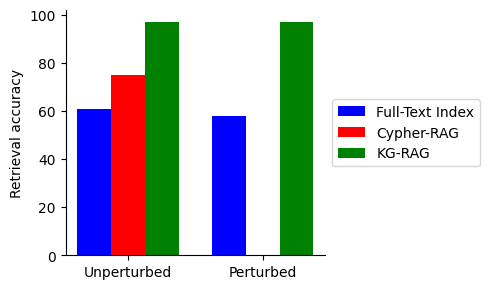

In [38]:
categories = ['Unperturbed', 'Perturbed']
full_text_index_rag_percentage = [full_text_index_based_total_correct_retrieval_percentage, full_text_index_based_total_correct_retrieval_perturbed_percentage]
neo4j_rag_percentage = [neo4j_rag_total_correct_retrieval_percentage, neo4j_rag_total_correct_retrieval_perturbed_percentage]
kg_rag_percentage = [kg_rag_total_correct_retrieval_percentage, kg_rag_total_correct_retrieval_perturbed_percentage]

full_text_index_color = 'blue'
neo4j_color = 'red'
kg_rag_color = 'green'

fig, ax = plt.subplots(figsize=(5, 3))
bar_width = 0.25
index = np.arange(len(categories))

ax.bar(index - bar_width, full_text_index_rag_percentage, bar_width, color=full_text_index_color, label='Full-Text Index')
ax.bar(index, neo4j_rag_percentage, bar_width, color=neo4j_color, label='Cypher-RAG')
ax.bar(index + bar_width, kg_rag_percentage, bar_width, color=kg_rag_color, label='KG-RAG')

ax.set_ylabel('Retrieval accuracy')
ax.set_xticks(index)
ax.set_xticklabels(categories)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.despine()
plt.tight_layout()
plt.show()

fig_path = '../data/results/figures'
os.makedirs(fig_path, exist_ok=True)
fig.savefig(os.path.join(fig_path, 'retrieval_accuracy_three_way_comparison.svg'), format='svg', bbox_inches='tight')


## Token usage plot for full-text, cypher-rag and kg-rag

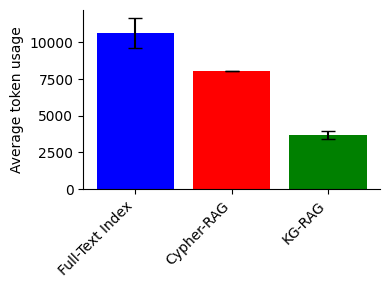

There is 53.9% reduction in token usage for KG-RAG compared to Cypher-RAG
There is 65.1% reduction in token usage for  KG-RAG compared compared to Full-Text Index


In [39]:

data.loc[:, 'token_usage_combined'] = 0.5*(data.token_usage + data.token_usage_after_perturbation)
neo4j_rag.loc[:, 'token_usage'] = 0.5*(neo4j_rag.total_tokens_used + neo4j_rag.total_tokens_used_perturbed)
kg_rag.loc[:, 'token_usage'] = 0.5*(kg_rag.total_tokens_used + kg_rag.total_tokens_used_perturbed)

neo4j_avg = neo4j_rag['token_usage'].mean()
neo4j_sem = neo4j_rag['token_usage'].sem()

kg_avg = kg_rag['token_usage'].mean()
kg_sem = kg_rag['token_usage'].sem()

full_text_avg = data['token_usage_combined'].mean()
full_text_sem = data['token_usage_combined'].sem()


fig = plt.figure(figsize=(4, 3))
plt.bar(0, full_text_avg, yerr=full_text_sem, color='blue', ecolor='black', capsize=5, label='Full-Text Index')
plt.bar(1, neo4j_avg, yerr=neo4j_sem, color='red', ecolor='black', capsize=5, label='Cypher-RAG')
plt.bar(2, kg_avg, yerr=kg_sem, color='green', ecolor='black', capsize=5, label='KG-RAG')

plt.ylabel('Average token usage')
plt.xticks([0, 1, 2], ['Full-Text Index', 'Cypher-RAG', 'KG-RAG'], rotation=45, ha='right')
plt.tight_layout()
sns.despine()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

percentage_of_reduction_cypher_to_kg = round(100*(neo4j_avg-kg_avg)/neo4j_avg,1)
percentage_of_reduction_fulltext_to_kg = round(100*(full_text_avg-kg_avg)/full_text_avg,1)

print(f'There is {percentage_of_reduction_cypher_to_kg}% reduction in token usage for KG-RAG compared to Cypher-RAG')
print(f'There is {percentage_of_reduction_fulltext_to_kg}% reduction in token usage for  KG-RAG compared compared to Full-Text Index')

fig_path = '../data/results/figures'
os.makedirs(fig_path, exist_ok=True)
fig.savefig(os.path.join(fig_path, 'token_usage_three_way_comparison.svg'), format='svg', bbox_inches='tight')

In [47]:
full_text_avg

10590.367088607594